In [1]:
import csv
import json
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

def load_all_outer_results_from_csv(filename='results.csv'):
    all_outer_results = {}
    with open(filename, 'r', newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            model = row['model']
            fold = int(row['fold'])
            metrics = json.loads(row['metrics'])
            confusion_matrix = json.loads(row['confusion_matrix'])
            fpr = json.loads(row['fpr'])
            tpr = json.loads(row['tpr'])
            labels = json.loads(row['labels'])
            preds = json.loads(row['preds'])

            if model not in all_outer_results:
                all_outer_results[model] = []

            all_outer_results[model].append({
                'fold': fold,
                'metrics': metrics,
                'confusion_matrix': confusion_matrix,
                'fpr': fpr,
                'tpr': tpr,
                'labels': labels,
                'preds': preds
            })
    return all_outer_results

In [19]:
loaded_results = load_all_outer_results_from_csv('results_bt2_kullandim.csv')


In [20]:
import numpy as np

def mean_std_confusion_matrix(results, model_name):
    """
    Verilen model için tüm fold'lardaki confusion matrix'lerin
    ortalamasını ve standart sapmasını döner.

    Args:
        results (dict): loaded_results formatında sözlük
        model_name (str): Ortalama ve std alınacak model adı

    Returns:
        tuple:
          - mean_cm (np.ndarray): Ortalama confusion matrix
          - std_cm (np.ndarray): Std sapma confusion matrix
    """
    cms = []
    if model_name not in results:
        raise ValueError(f"Model '{model_name}' results not found!")

    for fold_result in results[model_name]:
        cm = np.array(fold_result['confusion_matrix'])
        cms.append(cm)

    if not cms:
        raise ValueError(f"No confusion matrices found for model '{model_name}'.")

    mean_cm = np.mean(cms, axis=0)
    std_cm = np.std(cms, axis=0)
    return mean_cm, std_cm


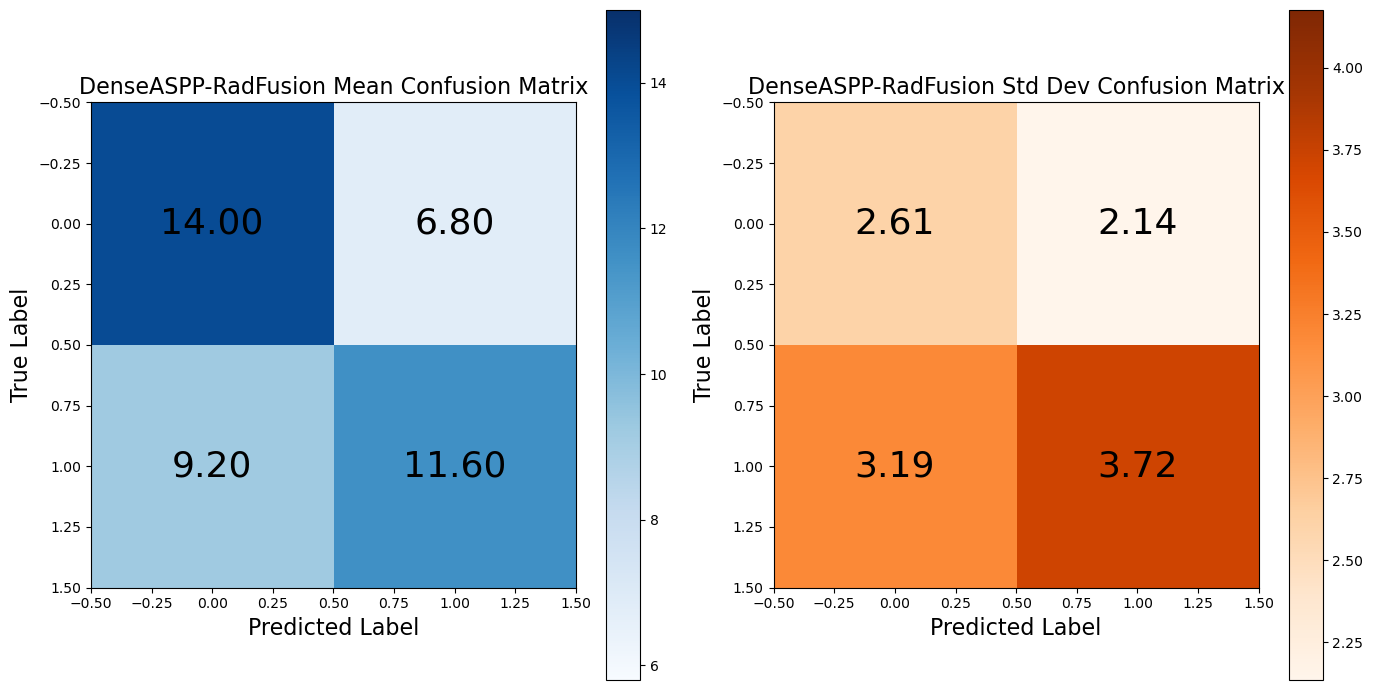

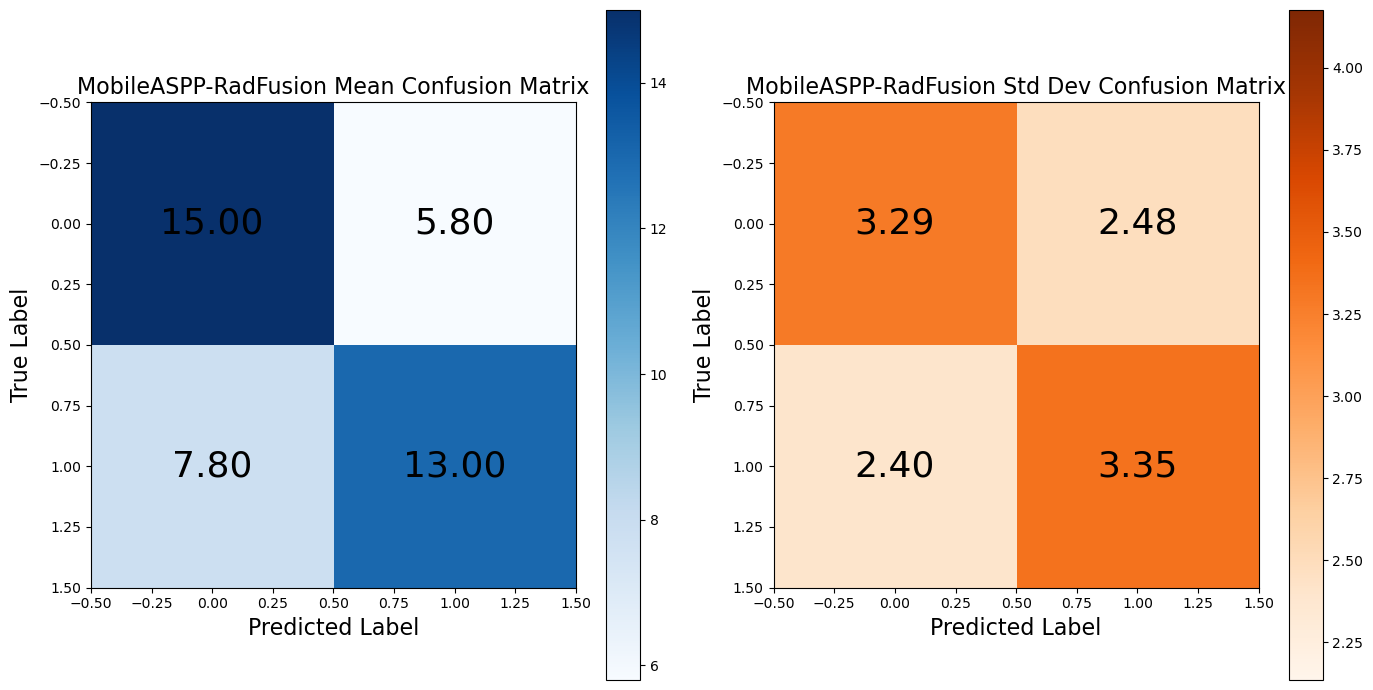

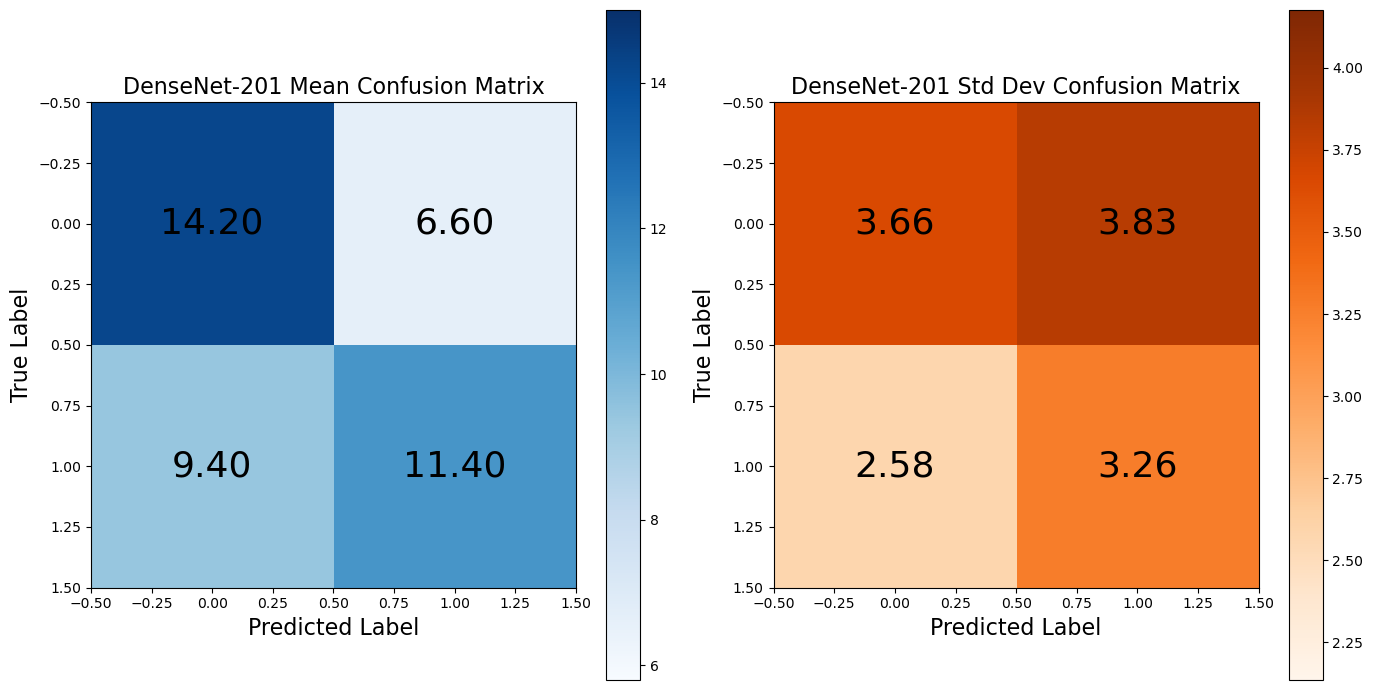

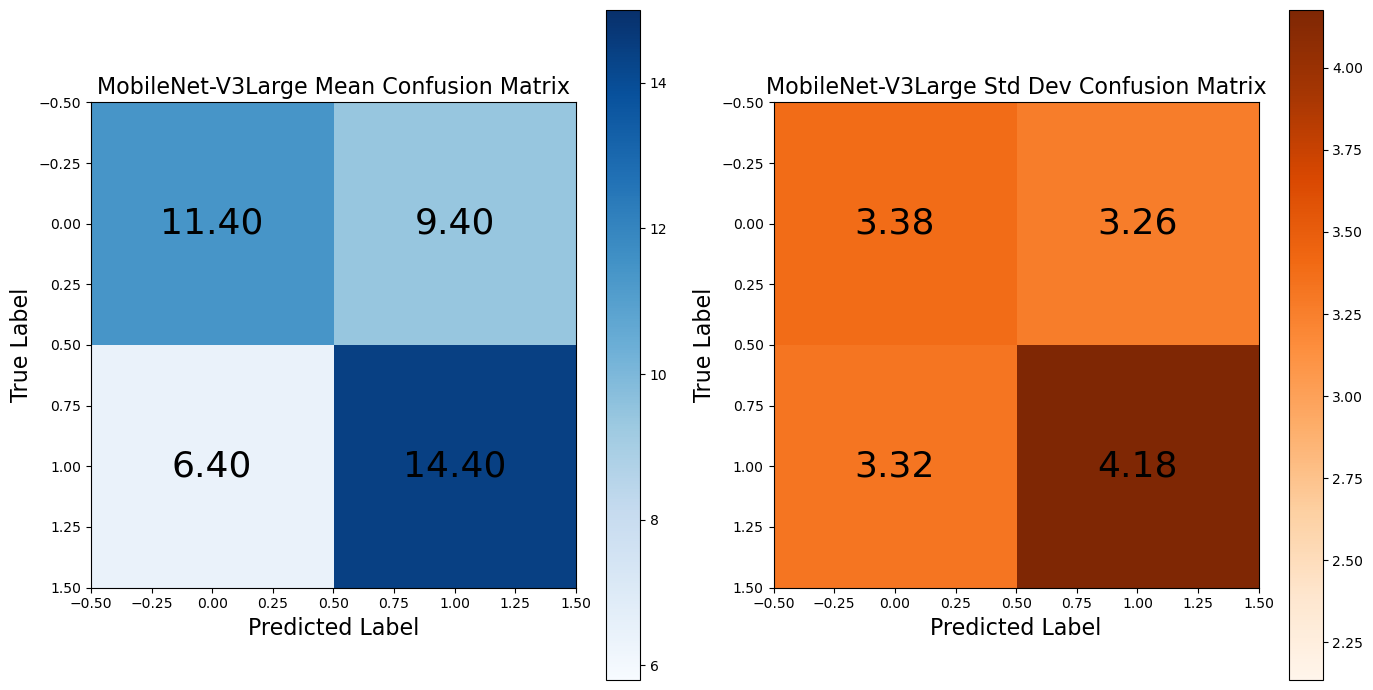

In [21]:
import matplotlib.pyplot as plt
import numpy as np

model_display_names = {
    'spatial_densenet': 'DenseASPP-RadFusion',
    'spatial_mobilenet': 'MobileASPP-RadFusion',
    'std_densenet': 'DenseNet-201',
    'std_mobilenet': 'MobileNet-V3Large'
}

def mean_std_confusion_matrix(results, model_name):
    cms = []
    if model_name not in results:
        raise ValueError(f"Model '{model_name}' results not found!")
    for fold_result in results[model_name]:
        cm = np.array(fold_result['confusion_matrix'])
        cms.append(cm)
    if not cms:
        raise ValueError(f"No confusion matrices found for model '{model_name}'.")
    mean_cm = np.mean(cms, axis=0)
    std_cm = np.std(cms, axis=0)
    return mean_cm, std_cm

# Tüm mean cm ve std cm'leri topla
all_mean_cms = []
all_std_cms = []
valid_models = []

for model_key in model_display_names.keys():
    try:
        mean_cm, std_cm = mean_std_confusion_matrix(loaded_results, model_key)
        all_mean_cms.append(mean_cm)
        all_std_cms.append(std_cm)
        valid_models.append(model_key)
    except Exception as e:
        print(f"Skipping {model_key} due to error: {e}")

# Mean confusion matrix'lerin ortak renk aralığı
vmin_mean = min(np.min(cm) for cm in all_mean_cms)
vmax_mean = max(np.max(cm) for cm in all_mean_cms)

# Std confusion matrix'lerin ortak renk aralığı
vmin_std = min(np.min(cm) for cm in all_std_cms)
vmax_std = max(np.max(cm) for cm in all_std_cms)

def plot_mean_std_confusion_matrix_with_values(mean_cm, std_cm, display_name, vmin_mean, vmax_mean, vmin_std, vmax_std, fontsize=16):
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    im1 = axes[0].imshow(mean_cm, interpolation='nearest', cmap=plt.cm.Blues, vmin=vmin_mean, vmax=vmax_mean)
    axes[0].set_title(f'{display_name} Mean Confusion Matrix', fontsize=fontsize)
    fig.colorbar(im1, ax=axes[0])
    for i in range(mean_cm.shape[0]):
        for j in range(mean_cm.shape[1]):
            axes[0].text(j, i, f"{mean_cm[i, j]:.2f}", ha="center", va="center", color="black", fontsize=fontsize+10 )
    
    im2 = axes[1].imshow(std_cm, interpolation='nearest', cmap=plt.cm.Oranges, vmin=vmin_std, vmax=vmax_std)
    axes[1].set_title(f'{display_name} Std Dev Confusion Matrix', fontsize=fontsize)
    fig.colorbar(im2, ax=axes[1])
    for i in range(std_cm.shape[0]):
        for j in range(std_cm.shape[1]):
            axes[1].text(j, i, f"{std_cm[i, j]:.2f}", ha="center", va="center", color="black", fontsize=fontsize+10)
    
    for ax in axes:
        ax.set_xlabel('Predicted Label', fontsize=fontsize)
        ax.set_ylabel('True Label', fontsize=fontsize)
    
    plt.tight_layout()
    plt.show()

# Tüm modeller için çizim
for model_key in valid_models:
    mean_cm, std_cm = mean_std_confusion_matrix(loaded_results, model_key)
    plot_mean_std_confusion_matrix_with_values(
        mean_cm, std_cm,
        model_display_names[model_key],
        vmin_mean, vmax_mean,
        vmin_std, vmax_std,
        fontsize=16
    )


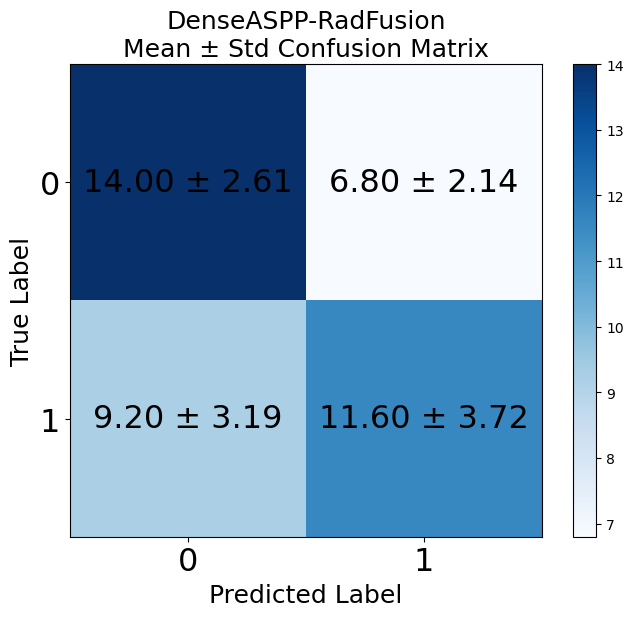

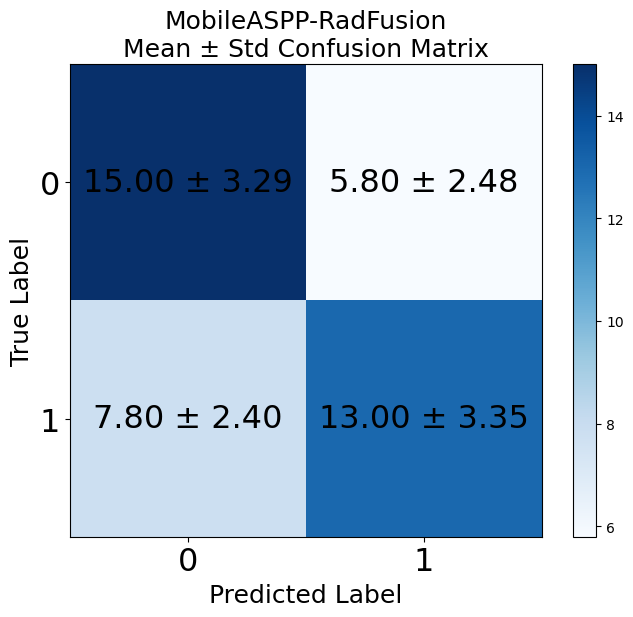

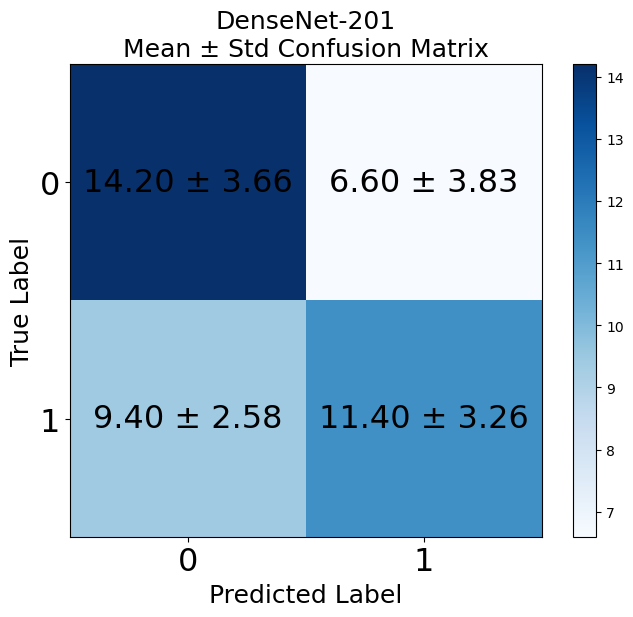

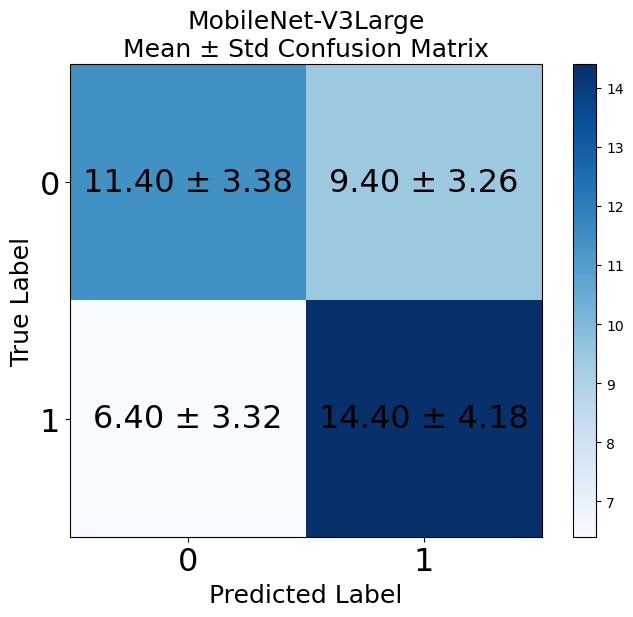

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def plot_combined_confusion_matrix(mean_cm, std_cm, display_name, fontsize=18, cmap=plt.cm.Blues):
    fig, ax = plt.subplots(figsize=(7, 6))

    # Görsel olarak mean değerleriyle heatmap çiz
    im = ax.imshow(mean_cm, interpolation='nearest', cmap=cmap)
    plt.title(f"{display_name}\nMean ± Std Confusion Matrix", fontsize=fontsize)
    fig.colorbar(im, ax=ax)

    # Her hücreye mean ± std değeri yaz
    for i in range(mean_cm.shape[0]):
        for j in range(mean_cm.shape[1]):
            mean_val = mean_cm[i, j]
            std_val = std_cm[i, j]
            text = f"{mean_val:.2f} ± {std_val:.2f}"
            ax.text(j, i, text, ha="center", va="center", color="black", fontsize=fontsize +5)

    ax.set_xlabel("Predicted Label", fontsize=fontsize)
    ax.set_ylabel("True Label", fontsize=fontsize)
    ax.set_xticks(np.arange(mean_cm.shape[1]))
    ax.set_yticks(np.arange(mean_cm.shape[0]))
    ax.tick_params(axis='both', labelsize=fontsize+5)
    plt.tight_layout()
    plt.show()
for model_key in valid_models:
    mean_cm, std_cm = mean_std_confusion_matrix(loaded_results, model_key)
    plot_combined_confusion_matrix(mean_cm, std_cm, model_display_names[model_key], fontsize=18)


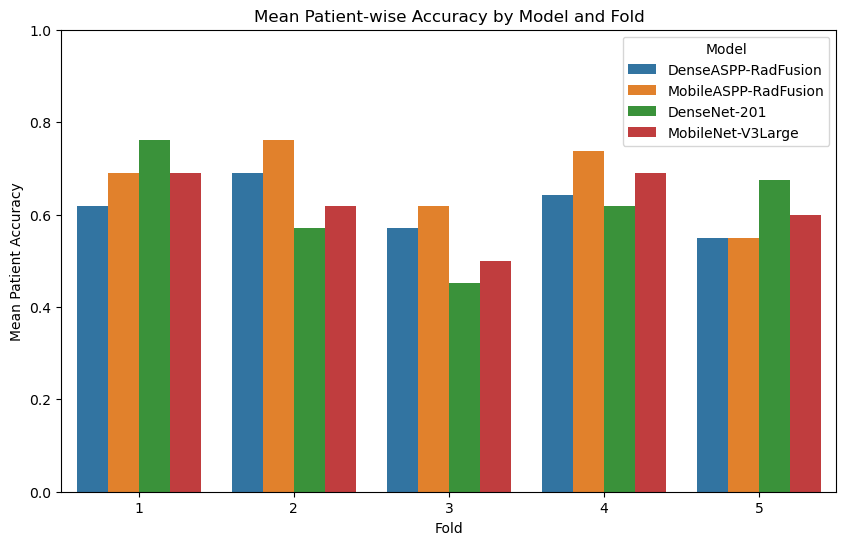

In [23]:
import pandas as pd

data = []
for model_key, display_name in model_display_names.items():
    for fold_result in loaded_results[model_key]:
        accuracies = patient_wise_accuracy(fold_result['labels'], fold_result['preds'])
        mean_acc = np.mean(accuracies)
        data.append({'Model': display_name, 'Fold': fold_result['fold'], 'Mean Patient Accuracy': mean_acc})

df = pd.DataFrame(data)

import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(data=df, x='Fold', y='Mean Patient Accuracy', hue='Model')
plt.title('Mean Patient-wise Accuracy by Model and Fold')
plt.ylim(0,1)
plt.show()


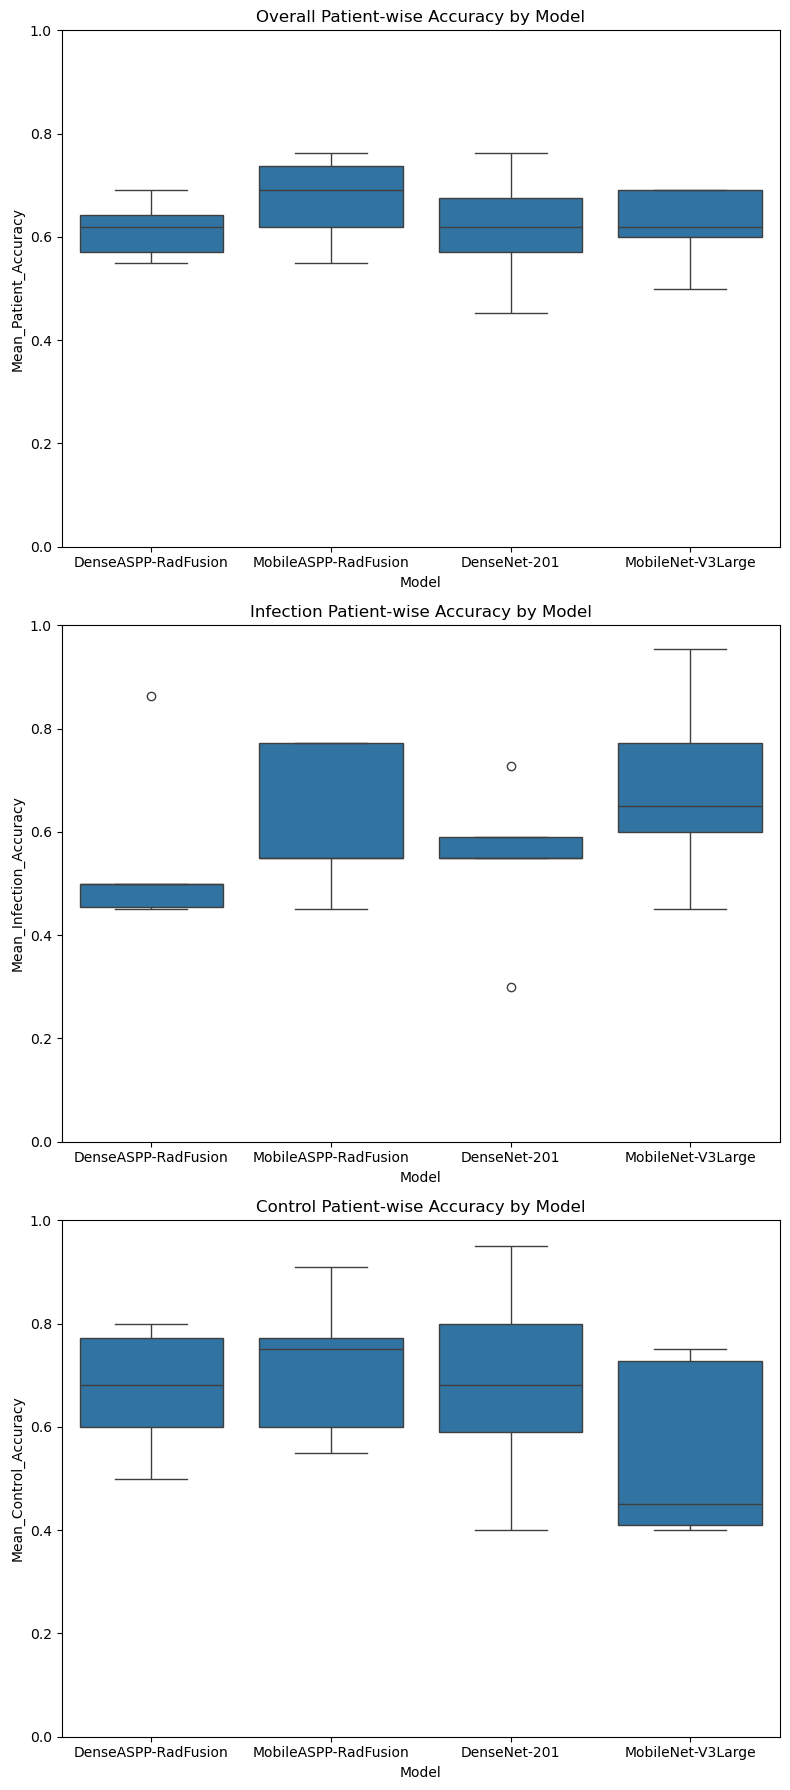

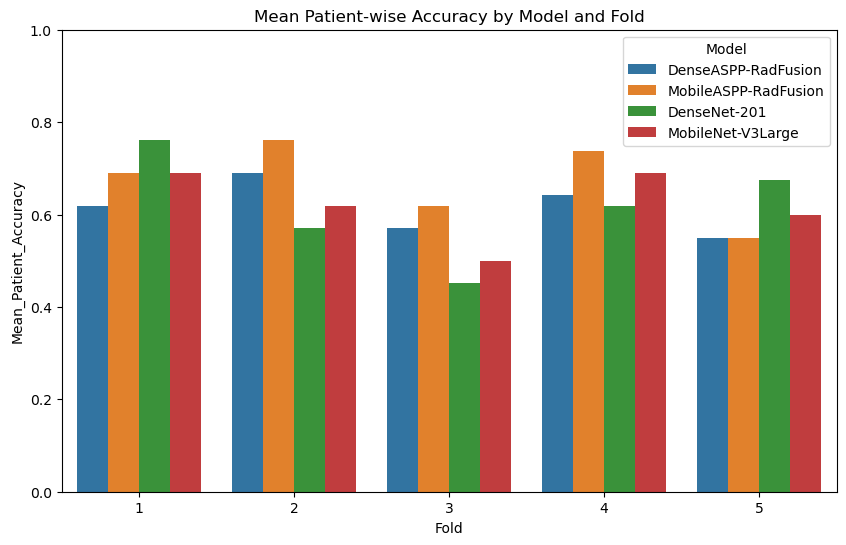

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Model isimlerini anlamlı şekilde eşle
model_display_names = {
    'spatial_densenet': 'DenseASPP-RadFusion',
    'spatial_mobilenet': 'MobileASPP-RadFusion',
    'std_densenet': 'DenseNet-201',
    'std_mobilenet': 'MobileNet-V3Large'
}

# 1) Hasta bazlı doğruluk hesaplama (genel)
def patient_wise_accuracy(labels, preds):
    n = len(labels)
    assert n % 2 == 0, "labels sayısı çift olmalı (2 örnek/hasta)"
    accuracies = []
    for i in range(0, n, 2):
        y_true = labels[i:i+2]
        y_pred = preds[i:i+2]
        correct = sum([yt == yp for yt, yp in zip(y_true, y_pred)])
        accuracies.append(correct / 2)
    return accuracies

# 2) Hasta bazlı doğruluk hesaplama (sınıf bazında)
def patient_wise_accuracy_by_class(labels, preds, class_label):
    n = len(labels)
    accuracies = []
    for i in range(0, n, 2):
        y_true = labels[i:i+2]
        y_pred = preds[i:i+2]
        if all(yt == class_label for yt in y_true):
            correct = sum([yt == yp for yt, yp in zip(y_true, y_pred)])
            accuracies.append(correct / 2)
    return accuracies

# 3) Veri hazırlama (fold ve model bazında hasta doğrulukları)
data = []
for model_key, display_name in model_display_names.items():
    for fold_result in loaded_results[model_key]:
        labels = fold_result['labels']
        preds = fold_result['preds']

        all_acc = patient_wise_accuracy(labels, preds)
        mean_all_acc = np.mean(all_acc) if all_acc else np.nan

        inf_acc = patient_wise_accuracy_by_class(labels, preds, class_label=1)
        mean_inf_acc = np.mean(inf_acc) if inf_acc else np.nan

        ctrl_acc = patient_wise_accuracy_by_class(labels, preds, class_label=0)
        mean_ctrl_acc = np.mean(ctrl_acc) if ctrl_acc else np.nan

        data.append({
            'Model': display_name,
            'Fold': fold_result['fold'],
            'Mean_Patient_Accuracy': mean_all_acc,
            'Mean_Infection_Accuracy': mean_inf_acc,
            'Mean_Control_Accuracy': mean_ctrl_acc
        })

df = pd.DataFrame(data)

# 4) Boxplot çizimi (model bazında dağılım)
plt.figure(figsize=(8, 18))

plt.subplot(3, 1, 1)
sns.boxplot(x='Model', y='Mean_Patient_Accuracy', data=df)
plt.title('Overall Patient-wise Accuracy by Model')
plt.ylim(0, 1)

plt.subplot(3, 1, 2)
sns.boxplot(x='Model', y='Mean_Infection_Accuracy', data=df)
plt.title('Infection Patient-wise Accuracy by Model')
plt.ylim(0, 1)

plt.subplot(3, 1, 3)
sns.boxplot(x='Model', y='Mean_Control_Accuracy', data=df)
plt.title('Control Patient-wise Accuracy by Model')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# 5) Fold ve model bazında grouped barplot (ortalama hasta doğruluğu)
plt.figure(figsize=(10,6))
sns.barplot(x='Fold', y='Mean_Patient_Accuracy', hue='Model', data=df)
plt.title('Mean Patient-wise Accuracy by Model and Fold')
plt.ylim(0, 1)
plt.show()


In [26]:
import pandas as pd
import numpy as np
import json

# CSV dosyasını oku
df = pd.read_csv('resultsBT2.csv')

# JSON string olan metrics sütununu dict haline getir
df['metrics_dict'] = df['metrics'].apply(json.loads)

# metrics dict sütununu açarak ayrı dataframe oluştur
metrics_df = pd.json_normalize(df['metrics_dict'])

# Model bilgisinin eklenmesi
metrics_df['model'] = df['model']

# Model bazında grupla (foldlar birleşik)
grouped_model = metrics_df.groupby('model').agg(['mean', 'std'])

metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']

# Ort ve std değerlerini formatlayarak dataframe oluştur
rows = []
for model_name in grouped_model.index:
    row = {'model': model_name}
    for metric in metrics:
        mean_val = grouped_model.loc[model_name][(metric, 'mean')]
        std_val = grouped_model.loc[model_name][(metric, 'std')]
        if pd.isna(std_val):
            std_val = 0.0
        row[metric] = f"{100*mean_val:.2f} ± {100*std_val:.2f}"
    rows.append(row)

result_df = pd.DataFrame(rows)
print(result_df)


               model      accuracy      precision         recall  \
0   spatial_densenet  60.52 ± 4.87   64.65 ± 8.03  47.64 ± 17.02   
1  spatial_mobilenet  59.07 ± 8.63   58.14 ± 8.86  70.18 ± 26.40   
2       std_densenet  57.26 ± 7.05  58.54 ± 13.48  44.64 ± 20.66   
3      std_mobilenet  59.62 ± 5.06   56.69 ± 4.68  77.36 ± 12.94   

              f1            auc  
0  53.46 ± 11.04   67.58 ± 5.08  
1  61.58 ± 13.00  71.48 ± 12.62  
2  49.37 ± 15.32   62.05 ± 7.31  
3   65.28 ± 7.26  61.33 ± 12.14  


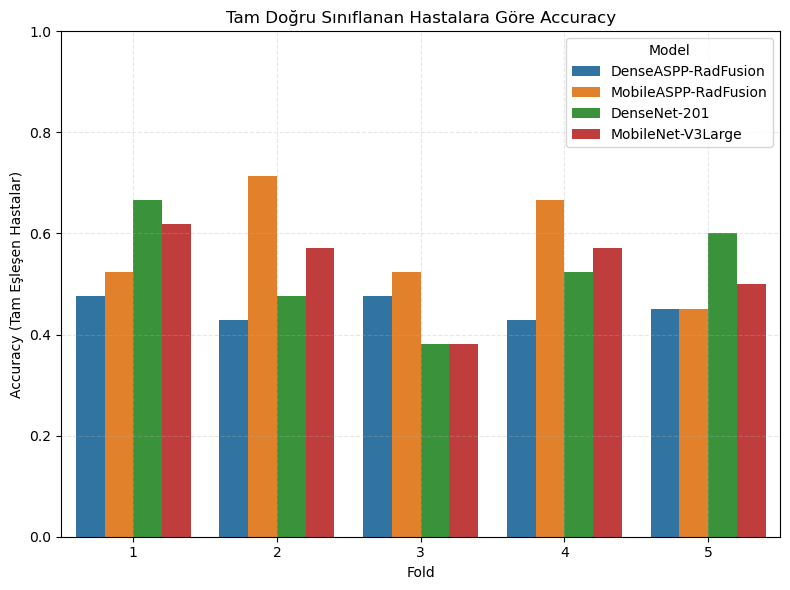

In [27]:
def strict_patient_accuracy_score(labels, preds):
    """
    Her hastanın iki örneği olduğu varsayımıyla,
    sadece her iki örnek de doğruysa 1 sayılır.
    Return: hasta bazlı accuracy (0.0 - 1.0)
    """
    n = len(labels)
    total_patients = n // 2
    correct_patients = 0

    for i in range(0, n, 2):
        y_true = labels[i:i+2]
        y_pred = preds[i:i+2]
        if y_true == y_pred:
            correct_patients += 1

    return correct_patients / total_patients


rows = []
for model_key, display_name in model_display_names.items():
    for fold_result in loaded_results[model_key]:
        labels = fold_result['labels']
        preds = fold_result['preds']
        acc = strict_patient_accuracy_score(labels, preds)
        rows.append({
            'Model': display_name,
            'Fold': fold_result['fold'],
            'Strict_Patient_Accuracy': acc
        })

strict_df = pd.DataFrame(rows)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.barplot(data=strict_df, x='Fold', y='Strict_Patient_Accuracy', hue='Model')
plt.title('Tam Doğru Sınıflanan Hastalara Göre Accuracy')
plt.ylim(0, 1.0)
plt.ylabel("Accuracy (Tam Eşleşen Hastalar)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


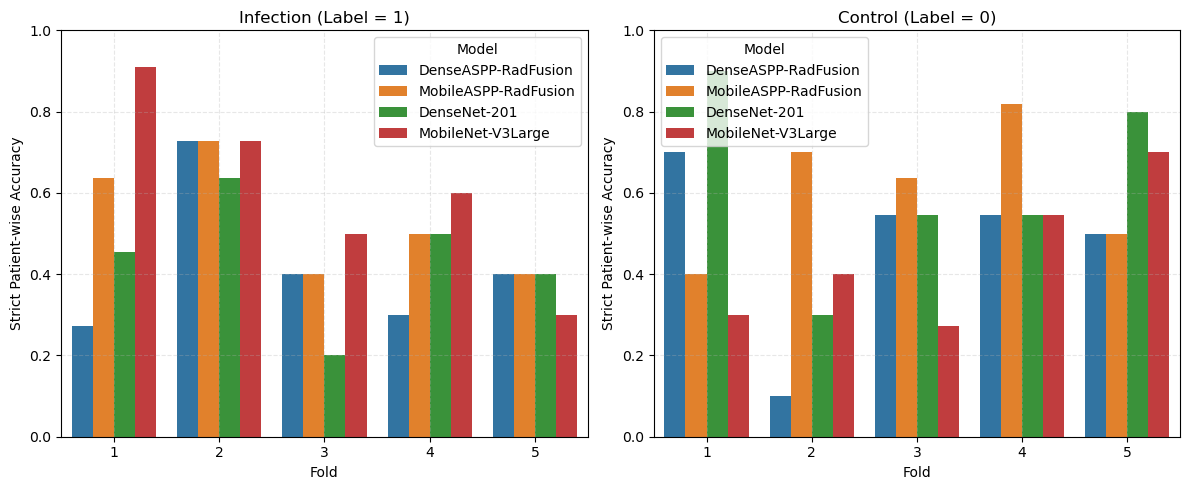

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Fonksiyon: Belirli bir sınıfa ait hastaların % kaçı tam doğru sınıflanmış
def strict_patient_accuracy_by_class(labels, preds, class_label):
    n = len(labels)
    total_patients = 0
    correct_patients = 0

    for i in range(0, n, 2):
        y_true = labels[i:i+2]
        y_pred = preds[i:i+2]
        if all(y == class_label for y in y_true):
            total_patients += 1
            if y_true == y_pred:
                correct_patients += 1

    if total_patients == 0:
        return np.nan  # o sınıfa ait hasta yoksa
    return correct_patients / total_patients

# Fold & model bazında hesapla
infection_rows = []
control_rows = []

for model_key, display_name in model_display_names.items():
    for fold_result in loaded_results[model_key]:
        labels = fold_result['labels']
        preds = fold_result['preds']
        fold = fold_result['fold']

        inf_acc = strict_patient_accuracy_by_class(labels, preds, class_label=1)
        ctrl_acc = strict_patient_accuracy_by_class(labels, preds, class_label=0)

        infection_rows.append({'Model': display_name, 'Fold': fold, 'Accuracy': inf_acc})
        control_rows.append({'Model': display_name, 'Fold': fold, 'Accuracy': ctrl_acc})

df_infection = pd.DataFrame(infection_rows)
df_control = pd.DataFrame(control_rows)
plt.figure(figsize=(12, 5))

# Infection
plt.subplot(1, 2, 1)
sns.barplot(data=df_infection, x='Fold', y='Accuracy', hue='Model')
plt.title("Infection (Label = 1)")
plt.ylabel("Strict Patient-wise Accuracy")
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.3)

# Control
plt.subplot(1, 2, 2)
sns.barplot(data=df_control, x='Fold', y='Accuracy', hue='Model')
plt.title("Control (Label = 0)")
plt.ylabel("Strict Patient-wise Accuracy")
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


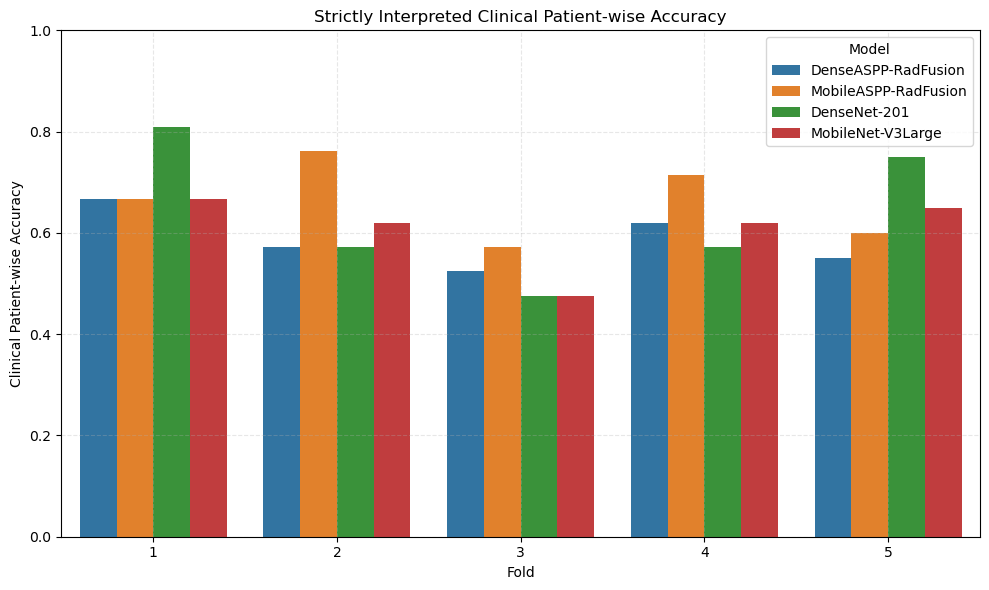

In [29]:
def patient_accuracy_clinical(labels, preds):
    """
    Klinik mantığa uygun hasta bazlı başarı hesabı:
    - Infection: en az bir örnek 1 ise doğru
    - Control: her iki örnek de 0 ise doğru
    """
    n = len(labels)
    assert n % 2 == 0, "Hasta başına 2 örnek bekleniyor"

    total_patients = n // 2
    correct_patients = 0

    for i in range(0, n, 2):
        y_true = labels[i:i+2]
        y_pred = preds[i:i+2]

        if 1 in y_true:  # Gerçek enfekte hasta
            if 1 in y_pred:
                correct_patients += 1
        else:  # Gerçek control hasta
            if y_pred == [0, 0]:
                correct_patients += 1

    return correct_patients / total_patients

results = []

for model_key, display_name in model_display_names.items():
    for fold_result in loaded_results[model_key]:
        acc = patient_accuracy_clinical(fold_result['labels'], fold_result['preds'])
        results.append({
            'Model': display_name,
            'Fold': fold_result['fold'],
            'Clinical_Patient_Accuracy': acc
        })

df_clinical = pd.DataFrame(results)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(data=df_clinical, x='Fold', y='Clinical_Patient_Accuracy', hue='Model')
plt.title("Strictly Interpreted Clinical Patient-wise Accuracy")
plt.ylabel("Clinical Patient-wise Accuracy")
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()



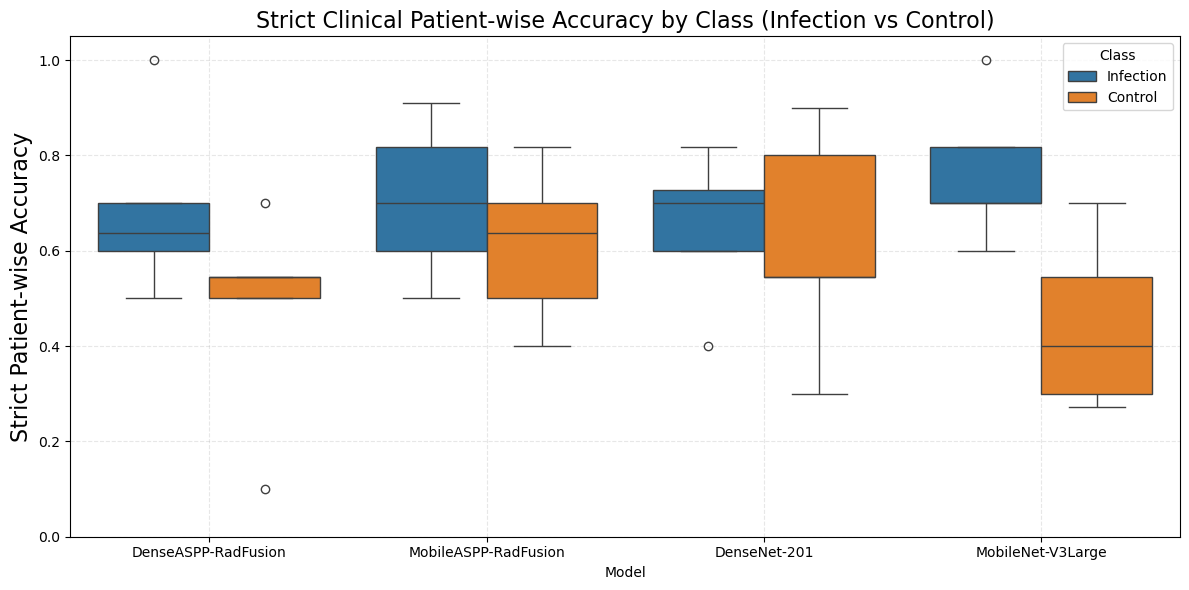

In [30]:
def clinical_accuracy_by_class(labels, preds, class_label):
    """
    Her fold'taki hasta çiftleri üzerinden class_label (0: control, 1: infection)
    için klinik doğruluk (strict) hesaplar.
    """
    n = len(labels)
    total_patients = 0
    correct_patients = 0

    for i in range(0, n, 2):
        y_true = labels[i:i+2]
        y_pred = preds[i:i+2]

        if all(yt == class_label for yt in y_true):
            total_patients += 1
            if class_label == 1:
                # En az bir 1 doğruysa enfeksiyon var kabul edilir
                if 1 in y_pred:
                    correct_patients += 1
            else:
                # Kontrol için her ikisi de 0 olmalı
                if y_pred == [0, 0]:
                    correct_patients += 1

    return correct_patients / total_patients if total_patients > 0 else np.nan
infection_rows = []
control_rows = []

for model_key, display_name in model_display_names.items():
    for fold_result in loaded_results[model_key]:
        fold = fold_result['fold']
        labels = fold_result['labels']
        preds = fold_result['preds']

        inf_acc = clinical_accuracy_by_class(labels, preds, class_label=1)
        ctrl_acc = clinical_accuracy_by_class(labels, preds, class_label=0)

        infection_rows.append({'Model': display_name, 'Fold': fold, 'Class': 'Infection', 'Accuracy': inf_acc})
        control_rows.append({'Model': display_name, 'Fold': fold, 'Class': 'Control', 'Accuracy': ctrl_acc})

df_clinical_by_class = pd.DataFrame(infection_rows + control_rows)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clinical_by_class, x='Model', y='Accuracy', hue='Class')
plt.title("Strict Clinical Patient-wise Accuracy by Class (Infection vs Control)",fontsize=16)
plt.ylabel("Strict Patient-wise Accuracy",fontsize=16)
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


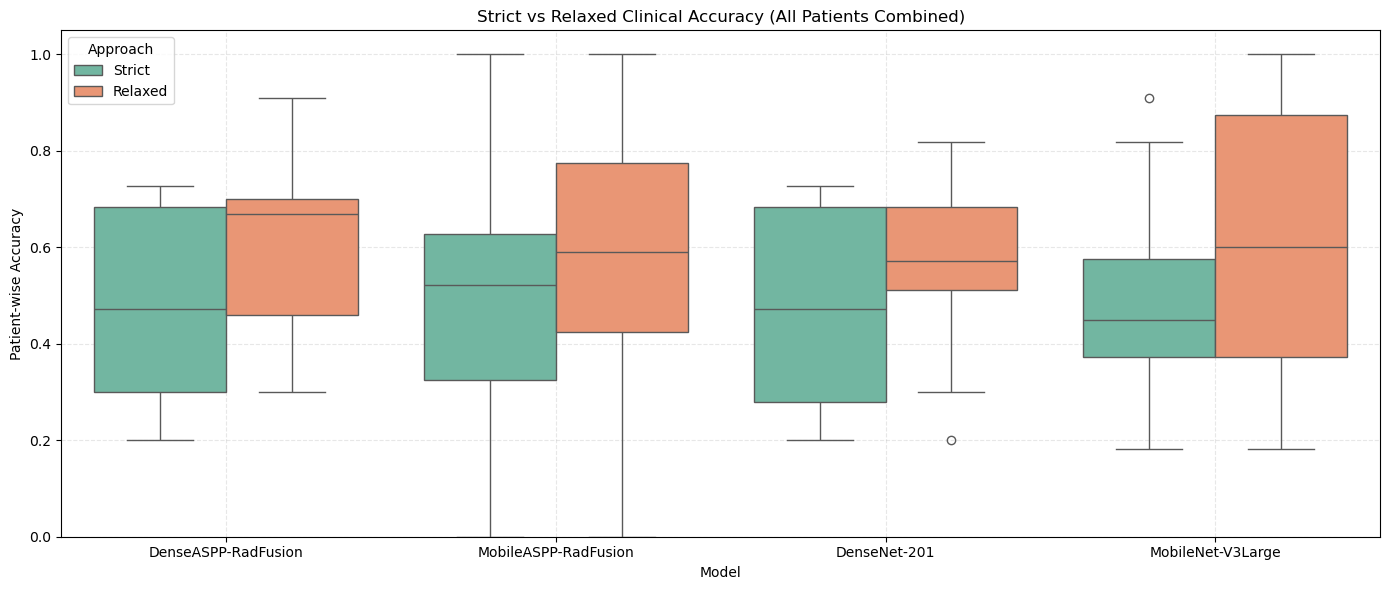

In [16]:
def strict_accuracy_by_class(labels, preds, class_label):
    n = len(labels)
    total_patients = 0
    correct_patients = 0

    for i in range(0, n, 2):
        y_true = labels[i:i+2]
        y_pred = preds[i:i+2]

        if all(yt == class_label for yt in y_true):
            total_patients += 1
            if y_true == y_pred:
                correct_patients += 1

    return correct_patients / total_patients if total_patients > 0 else np.nan
def relaxed_accuracy_by_class(labels, preds, class_label):
    n = len(labels)
    total_patients = 0
    correct_patients = 0

    for i in range(0, n, 2):
        y_true = labels[i:i+2]
        y_pred = preds[i:i+2]

        if all(yt == class_label for yt in y_true):
            total_patients += 1
            if class_label == 1:
                if 1 in y_pred:
                    correct_patients += 1
            else:
                if y_pred == [0, 0]:
                    correct_patients += 1

    return correct_patients / total_patients if total_patients > 0 else np.nan
rows = []

for model_key, display_name in model_display_names.items():
    for fold_result in loaded_results[model_key]:
        fold = fold_result['fold']
        labels = fold_result['labels']
        preds = fold_result['preds']

        for class_label, class_name in zip([1, 0], ['Infection', 'Control']):
            acc_strict = strict_accuracy_by_class(labels, preds, class_label)
            acc_relaxed = relaxed_accuracy_by_class(labels, preds, class_label)

            rows.append({
                'Model': display_name,
                'Fold': fold,
                'Class': class_name,
                'Approach': 'Strict',
                'Accuracy': acc_strict
            })
            rows.append({
                'Model': display_name,
                'Fold': fold,
                'Class': class_name,
                'Approach': 'Relaxed',
                'Accuracy': acc_relaxed
            })

df_compare = pd.DataFrame(rows)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_compare, x='Model', y='Accuracy', hue='Approach', palette='Set2')
plt.title("Strict vs Relaxed Clinical Accuracy (All Patients Combined)")
plt.ylabel("Patient-wise Accuracy")
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


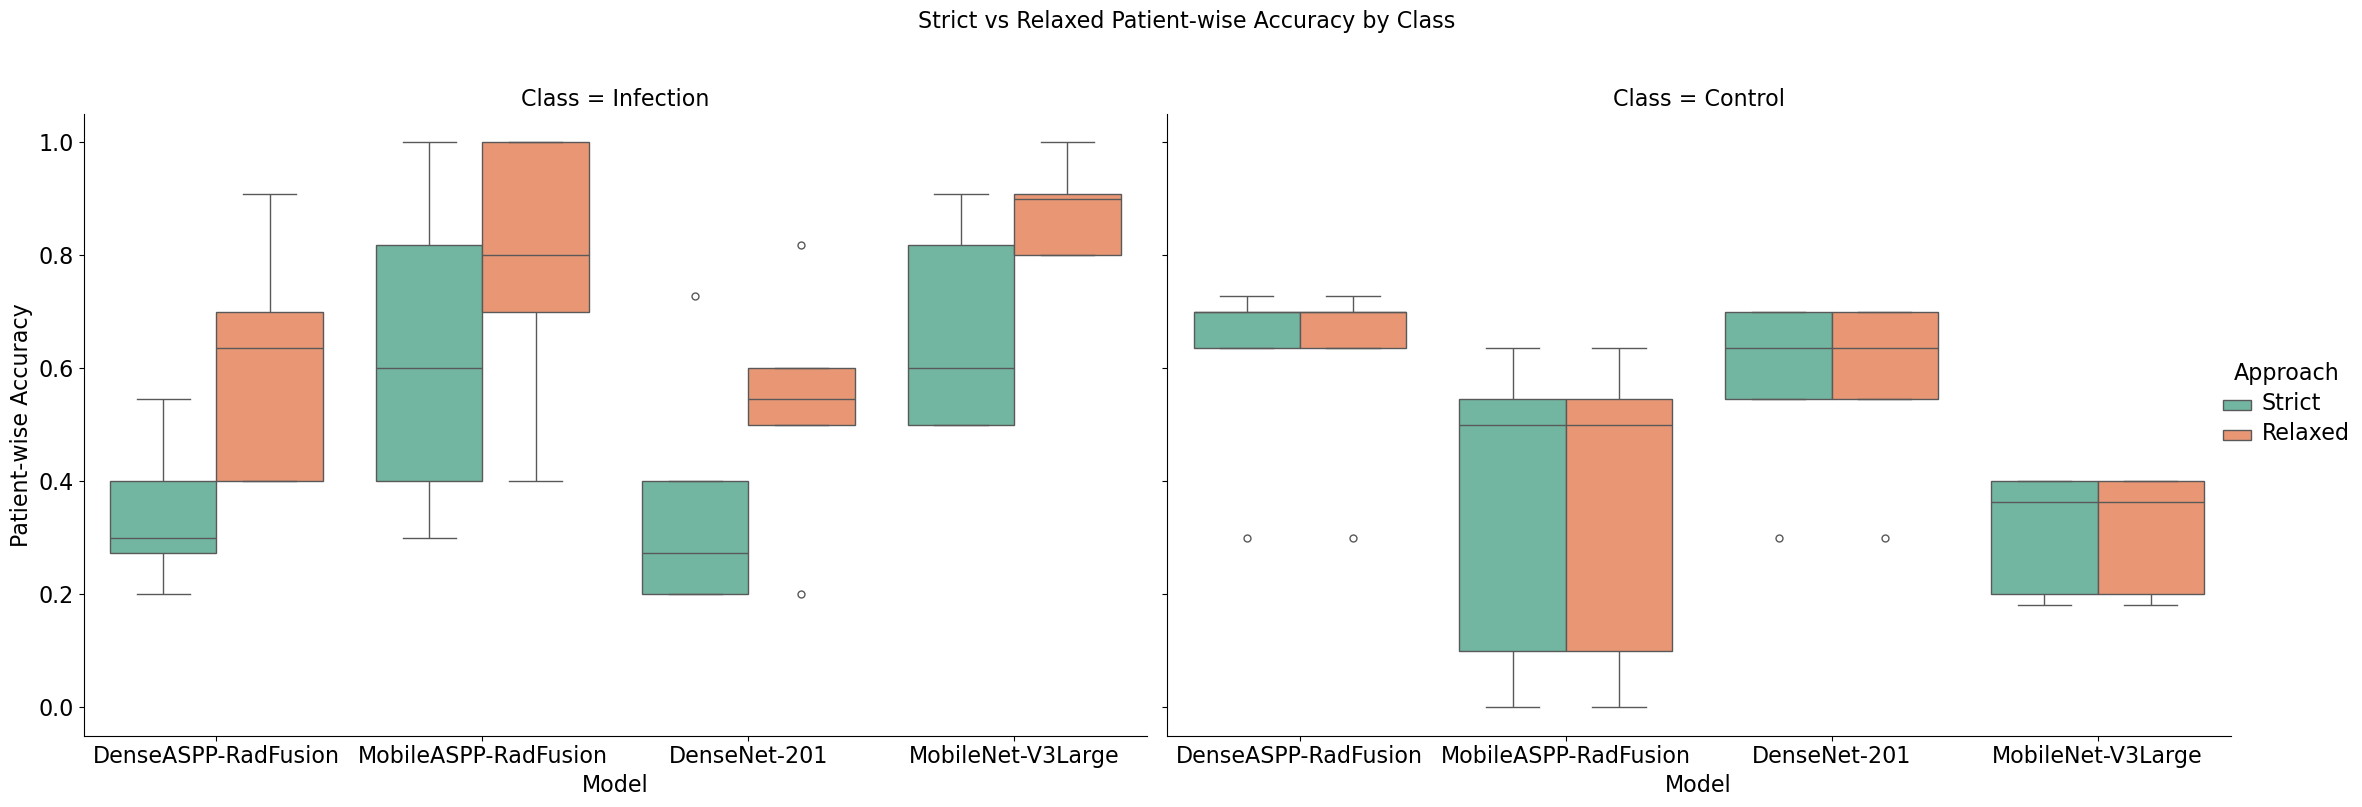

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Grafik oluştur
g = sns.catplot(
    data=df_compare,
    x='Model', y='Accuracy', hue='Approach',
    col='Class', kind='box', height=8, aspect=1.4,
    palette='Set2'
)

# Başlık
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Strict vs Relaxed Patient-wise Accuracy by Class", fontsize=16)

# Alt başlık (her panelin başlığı)
for ax in g.axes.flatten():
    ax.set_title(ax.get_title(), fontsize=16)
    ax.set_xlabel("Model", fontsize=16)
    ax.set_ylabel("Patient-wise Accuracy", fontsize=16)

# Tick label fontsize
for ax in g.axes.flatten():
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

# Legend fontsize
g._legend.set_title("Approach")
for text in g._legend.texts:
    text.set_fontsize(16)
g._legend.set_title("Approach", prop={'size': 16})
